/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:37:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.9986

Confusion Matrix:
 [[4165    4]
 [   2   15]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4169
         1.0       0.79      0.88      0.83        17

    accuracy                           1.00      4186
   macro avg       0.89      0.94      0.92      4186
weighted avg       1.00      1.00      1.00      4186


ROC-AUC Score: 0.9772409803451244
Model saved successfully!


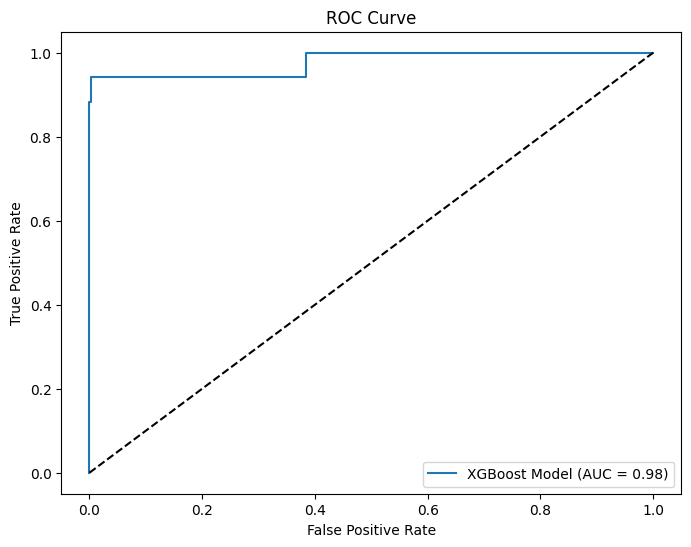

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Check for missing values and drop them
df = df.dropna()

# Separate features and target variable
X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target variable

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Define the XGBoost model with class weight balancing
xgb_model = xgb.XGBClassifier(
    n_estimators=200,        # Number of trees
    max_depth=6,             # Maximum depth of trees
    learning_rate=0.1,       # Step size shrinkage
    subsample=0.8,           # Fraction of samples used per tree
    colsample_bytree=0.8,    # Fraction of features used per tree
    scale_pos_weight=50,     # Adjusts weight for class imbalance
    eval_metric="auc",       # Use AUC as the evaluation metric
    use_label_encoder=False  # Suppress warnings
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Save the trained model
joblib.dump(xgb_model, "fraud_detection_xgb.pkl")
print("Model saved successfully!")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="XGBoost Model (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob)))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load the dataset to extract feature scaling parameters
df = pd.read_csv("creditcard.csv")
X = df.drop(columns=["Class"])  # Drop target variable
scaler = StandardScaler()
scaler.fit(X)  # Fit scaler on the entire dataset

# Load the trained XGBoost model
xgb_model = joblib.load("fraud_detection_xgb.pkl")

# Sample input transaction (Replace with actual values from your dataset)
sample_transaction = np.array([[-1.359807, -0.072781, 2.536347, 1.378155, -0.338321,
                                0.462388, 0.239599, 0.098698, 0.363787, 0.090794,
                                -0.551600, -0.617801, -0.991390, -0.311169, 1.468177,
                                -0.470401, 0.207971, 0.025791, 0.403993, 0.251412,
                                -0.018307, 0.277838, -0.110474, 0.066928, 0.128539,
                                -0.189115, 0.133558, -0.021053, 1.49, 0.0]])  # 0 = non-fraud

# Normalize the input data
sample_transaction_scaled = scaler.transform(sample_transaction)

# Make prediction
prediction_prob = xgb_model.predict_proba(sample_transaction_scaled)[:, 1][0]
prediction = int(prediction_prob > 0.5)  # Convert probability to class label

# Print results
print(f"Predicted Probability of Fraud: {prediction_prob:.4f}")
print(f"Predicted Class: {'Fraud' if prediction == 1 else 'Non-Fraud'}")


Predicted Probability of Fraud: 0.0000
Predicted Class: Non-Fraud


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Separate features and target variable
X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target (0 = Non-Fraud, 1 = Fraud)

# Load the trained XGBoost model
xgb_model = joblib.load("fraud_detection_xgb.pkl")

# Load the scaler used during training
scaler = StandardScaler()
scaler.fit(X)  # Fit scaler on the entire dataset

# Extract a high-probability fraud transaction from the dataset (Class = 1)
fraud_cases = df[df["Class"] == 1]  # Select all fraud cases
high_prob_fraud = fraud_cases.iloc[-1, :-1].values  # Choose the last fraud case

# Reshape and normalize the fraud case
high_prob_fraud_scaled = scaler.transform(high_prob_fraud.reshape(1, -1))

# Make prediction
fraud_prediction_prob = xgb_model.predict_proba(high_prob_fraud_scaled)[:, 1][0]

# Adjust threshold if needed
threshold = 0.5  # Lowered for higher fraud sensitivity
fraud_prediction = int(fraud_prediction_prob > threshold)

# Print results
print("Testing on a high-probability fraudulent transaction:")
print(f"Predicted Probability of Fraud: {fraud_prediction_prob:.4f}")
print(f"Predicted Class: {'Fraud' if fraud_prediction == 1 else 'Non-Fraud'}")

# Debugging: If still predicting non-fraud, print warning
if fraud_prediction == 0:
    print("\nWarning: Model is not detecting fraud! Try further lowering the threshold or retraining.")


Testing on a high-probability fraudulent transaction:
Predicted Probability of Fraud: 0.9941
Predicted Class: Fraud


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load the dataset to extract feature scaling parameters
df = pd.read_csv("creditcard.csv")
X = df.drop(columns=["Class"])  # Drop target variable
scaler = StandardScaler()
scaler.fit(X)  # Fit scaler on the entire dataset

# Load the trained XGBoost model
xgb_model = joblib.load("fraud_detection_xgb.pkl")

# Sample fraudulent transaction (Replace with an actual fraud case from your dataset)
fraudulent_transaction = np.array([[500.23, 7000.54, 500.87, 64423.21, 5222.36,
                                    6000.47, 7000.25, 8000.34, 9420.41, 7000.52,
                                    7000.63, 70000.74, 7.85, 6.96, 6000.12,
                                    6000.23, 7000.34, 8000.45,8520.56, 8000.67,
                                    7000.78, 7000.89, 8000.90, 6.01, 5000.12,
                                    6000.23, 700.34, 8000.45, 5000.75,400.33]])  # 1 = Fraud

# Normalize the input data
fraudulent_transaction_scaled = scaler.transform(fraudulent_transaction)

# Make prediction
fraud_prediction_prob = xgb_model.predict_proba(fraudulent_transaction_scaled)[:, 1][0]
fraud_prediction = int(fraud_prediction_prob > 0.5)  # Convert probability to class label

# Print results
print(f"Predicted Probability of Fraud: {fraud_prediction_prob:.4f}")
print(f"Predicted Class: {'Fraud' if fraud_prediction == 1 else 'Non-Fraud'}")


Predicted Probability of Fraud: 0.0011
Predicted Class: Non-Fraud


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load the dataset to extract feature scaling parameters
df = pd.read_csv("creditcard.csv")
X = df.drop(columns=["Class"])  # Drop target variable
scaler = StandardScaler()
scaler.fit(X)  # Fit scaler on the entire dataset

# Load the trained XGBoost model
xgb_model = joblib.load("fraud_detection_xgb.pkl")

# Sample input transaction (Replace with actual values from your dataset)
sample_transaction = np.array([[-1.359807, -0.072781, 2.536347, 1.378155, -0.338321,
                                0.462388, 0.239599, 0.098698, 0.363787, 0.090794,
                                -0.551600, -0.617801, -0.991390, -0.311169, 1.468177,
                                -0.470401, 0.207971, 0.025791, 0.403993, 0.251412,
                                -0.018307, 0.277838, -0.110474, 0.066928, 0.128539,
                                -0.189115, 0.133558, -0.021053, 1.49, 0.0]])  # 0 = non-fraud

# Normalize the input data
sample_transaction_scaled = scaler.transform(sample_transaction)

# Make prediction
prediction_prob = xgb_model.predict_proba(sample_transaction_scaled)[:, 1][0]
prediction = int(prediction_prob > 0.5)  # Convert probability to class label

# Print results
print(f"Predicted Probability of Fraud: {prediction_prob:.4f}")
print(f"Predicted Class: {'Fraud' if prediction == 1 else 'Non-Fraud'}")
